In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['/mnt/ceph/users/blyo1/projects', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python310.zip', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/lib-dynload', '', '/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages']


# VAE

In [30]:
import argparse
from b_models.vae import VariableConvEncoder, VariableConvDecoder, VAE, UNetDecoder

num_channels = 1
image_dims = 32
latent_dims = 6

enc = VariableConvEncoder(
    num_channels,
    image_dims,
    latent_dims, 
    channels=[32, 36, 64], 
    bias=True,
)

dec = VariableConvDecoder(
    num_channels,
    image_dims,
    latent_dims,
    channels=[64, 36, 32],  # output_channels, kernel_size, stride, padding
    output_channels=1,
    bias=True,
)

# args = argparse.Namespace()
# args.num_channels = num_channels
# args.kernel_size = 3
# args.padding = 1
# args.time_channels = 32
# args.image_dims = image_dims
# args.pool_window = 2
# args.num_blocks = 2
# args.num_enc_conv = 2
# args.num_mid_conv = 2
# args.num_dec_conv = 2
# args.latent_dims = latent_dims
# args.num_kernels = 64
# args.bias = True
# dec = UNetDecoder(args)

vae = VAE(
    encoder=enc,
    decoder=dec,
    kl_reduction="mean"
)

In [31]:
# count number of parameters in vae
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Number of parameters in VAE: {num_params}")

Number of parameters in VAE: 103829


In [4]:
example_image = torch.randn(1, num_channels, image_dims, image_dims)
# normalize the image to (-1, 1)
example_image = example_image * 2 - 1

vae(example_image)[0].shape

torch.Size([1, 1, 32, 32])

now train the model on the dataset

In [6]:
from utils.hdisks1 import random_two_disk_dataset
# random sample of disks
data = random_two_disk_dataset(
    delta_id=.2,
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
    # ib=0.2
)[0]

In [7]:
from utils.hdisks2 import random_two_disk_dataset

data = random_two_disk_dataset(
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
)[0]

In [8]:
from utils.disks import DiskDataset
from torch.utils.data import DataLoader
dataset = DiskDataset(data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [9]:
for batch in dataloader:
    print(batch.shape)
    print(batch.min())
    print(batch.max())
    break

torch.Size([256, 1, 32, 32])
tensor(-0.9961)
tensor(0.9974)


In [32]:
# now train model
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

vae.train()
vae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
n_epochs = 200

# kl annealing schedule
kl_weight = 0.0
def kl_annealing(epoch, n_epochs_anneal, schedule='linear', end_value = 1.):
    if schedule == 'linear':
        if epoch < n_epochs_anneal:
            kl_weight = end_value * (epoch / n_epochs_anneal)
        else:
            kl_weight = end_value
    elif schedule == 'cosine':
        if epoch < n_epochs_anneal:
            # cosine annealing from 0 to 1
            kl_weight = (1 - 0.5 * (1 + np.cos(np.pi * epoch / n_epochs_anneal))) * end_value
        else:
            kl_weight = end_value
    elif schedule == "constant":
        kl_weight = end_value
    return kl_weight

for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = vae(batch)[0]
        mse_loss = criterion(output, batch)
        kl_weight = kl_annealing(epoch, 10, schedule='constant', end_value = 1e-7)
        # kl_weight = 1
        kl_loss = vae.kl
        # Combine losses
        loss = mse_loss + kl_loss * kl_weight
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}, KL weight: {kl_weight:.4f}, KL Loss: {kl_loss.item():.4f}")

  0%|                                                                                     | 0/200 [00:00<?, ?it/s]

  0%|▍                                                                            | 1/200 [00:01<04:25,  1.33s/it]

Epoch 1, Loss: 0.0171, MSE Loss: 0.0170, KL weight: 0.0000, KL Loss: 48.8948


  1%|▊                                                                            | 2/200 [00:02<04:23,  1.33s/it]

Epoch 2, Loss: 0.0170, MSE Loss: 0.0170, KL weight: 0.0000, KL Loss: 45.6082


  2%|█▏                                                                           | 3/200 [00:03<04:21,  1.33s/it]

Epoch 3, Loss: 0.0132, MSE Loss: 0.0132, KL weight: 0.0000, KL Loss: 46.7967


  2%|█▌                                                                           | 4/200 [00:05<04:20,  1.33s/it]

Epoch 4, Loss: 0.0100, MSE Loss: 0.0100, KL weight: 0.0000, KL Loss: 45.2733


  2%|█▉                                                                           | 5/200 [00:06<04:18,  1.33s/it]

Epoch 5, Loss: 0.0074, MSE Loss: 0.0074, KL weight: 0.0000, KL Loss: 48.4125


  3%|██▎                                                                          | 6/200 [00:07<04:17,  1.33s/it]

Epoch 6, Loss: 0.0059, MSE Loss: 0.0059, KL weight: 0.0000, KL Loss: 51.0185


  4%|██▋                                                                          | 7/200 [00:09<04:15,  1.33s/it]

Epoch 7, Loss: 0.0066, MSE Loss: 0.0066, KL weight: 0.0000, KL Loss: 51.7659


  4%|███                                                                          | 8/200 [00:10<04:14,  1.33s/it]

Epoch 8, Loss: 0.0050, MSE Loss: 0.0050, KL weight: 0.0000, KL Loss: 51.4735


  4%|███▍                                                                         | 9/200 [00:11<04:12,  1.32s/it]

Epoch 9, Loss: 0.0052, MSE Loss: 0.0052, KL weight: 0.0000, KL Loss: 52.2381


  5%|███▊                                                                        | 10/200 [00:13<04:11,  1.33s/it]

Epoch 10, Loss: 0.0042, MSE Loss: 0.0042, KL weight: 0.0000, KL Loss: 54.0526


  6%|████▏                                                                       | 11/200 [00:14<04:10,  1.33s/it]

Epoch 11, Loss: 0.0042, MSE Loss: 0.0042, KL weight: 0.0000, KL Loss: 51.4153


 10%|███████▉                                                                    | 21/200 [00:27<03:58,  1.33s/it]

Epoch 21, Loss: 0.0034, MSE Loss: 0.0034, KL weight: 0.0000, KL Loss: 48.5165


 16%|███████████▊                                                                | 31/200 [00:41<03:45,  1.33s/it]

Epoch 31, Loss: 0.0023, MSE Loss: 0.0023, KL weight: 0.0000, KL Loss: 49.6190


 20%|███████████████▌                                                            | 41/200 [00:54<03:31,  1.33s/it]

Epoch 41, Loss: 0.0021, MSE Loss: 0.0021, KL weight: 0.0000, KL Loss: 51.1529


 26%|███████████████████▍                                                        | 51/200 [01:07<03:18,  1.33s/it]

Epoch 51, Loss: 0.0017, MSE Loss: 0.0017, KL weight: 0.0000, KL Loss: 48.5338


 30%|███████████████████████▏                                                    | 61/200 [01:21<03:04,  1.33s/it]

Epoch 61, Loss: 0.0019, MSE Loss: 0.0019, KL weight: 0.0000, KL Loss: 48.2033


 36%|██████████████████████████▉                                                 | 71/200 [01:34<02:52,  1.33s/it]

Epoch 71, Loss: 0.0016, MSE Loss: 0.0016, KL weight: 0.0000, KL Loss: 46.5899


 40%|██████████████████████████████▊                                             | 81/200 [01:47<02:39,  1.34s/it]

Epoch 81, Loss: 0.0015, MSE Loss: 0.0015, KL weight: 0.0000, KL Loss: 48.2233


 46%|██████████████████████████████████▌                                         | 91/200 [02:01<02:25,  1.33s/it]

Epoch 91, Loss: 0.0016, MSE Loss: 0.0015, KL weight: 0.0000, KL Loss: 48.9921


 50%|█████████████████████████████████████▉                                     | 101/200 [02:14<02:12,  1.33s/it]

Epoch 101, Loss: 0.0014, MSE Loss: 0.0014, KL weight: 0.0000, KL Loss: 46.5526


 56%|█████████████████████████████████████████▋                                 | 111/200 [02:27<01:58,  1.33s/it]

Epoch 111, Loss: 0.0014, MSE Loss: 0.0014, KL weight: 0.0000, KL Loss: 46.4958


 60%|█████████████████████████████████████████████▍                             | 121/200 [02:41<01:45,  1.33s/it]

Epoch 121, Loss: 0.0011, MSE Loss: 0.0011, KL weight: 0.0000, KL Loss: 45.3460


 66%|█████████████████████████████████████████████████▏                         | 131/200 [02:54<01:31,  1.33s/it]

Epoch 131, Loss: 0.0011, MSE Loss: 0.0011, KL weight: 0.0000, KL Loss: 45.1323


 70%|████████████████████████████████████████████████████▉                      | 141/200 [03:07<01:18,  1.33s/it]

Epoch 141, Loss: 0.0012, MSE Loss: 0.0012, KL weight: 0.0000, KL Loss: 45.9092


 76%|████████████████████████████████████████████████████████▋                  | 151/200 [03:21<01:05,  1.34s/it]

Epoch 151, Loss: 0.0009, MSE Loss: 0.0009, KL weight: 0.0000, KL Loss: 45.0829


 80%|████████████████████████████████████████████████████████████▍              | 161/200 [03:34<00:51,  1.33s/it]

Epoch 161, Loss: 0.0011, MSE Loss: 0.0011, KL weight: 0.0000, KL Loss: 45.0632


 86%|████████████████████████████████████████████████████████████████▏          | 171/200 [03:47<00:38,  1.33s/it]

Epoch 171, Loss: 0.0010, MSE Loss: 0.0010, KL weight: 0.0000, KL Loss: 44.9005


 90%|███████████████████████████████████████████████████████████████████▉       | 181/200 [04:01<00:25,  1.32s/it]

Epoch 181, Loss: 0.0010, MSE Loss: 0.0010, KL weight: 0.0000, KL Loss: 44.5918


 96%|███████████████████████████████████████████████████████████████████████▋   | 191/200 [04:14<00:11,  1.33s/it]

Epoch 191, Loss: 0.0011, MSE Loss: 0.0011, KL weight: 0.0000, KL Loss: 45.5784


100%|███████████████████████████████████████████████████████████████████████████| 200/200 [04:26<00:00,  1.33s/it]


In [98]:
# save model
mode = 'load'

save_dir = "./b_models/saved_weights"
if mode == "save":
    torch.save(vae.state_dict(), os.path.join(save_dir, 'vae.pth'))
elif mode == "load":
    vae.load_state_dict(torch.load(os.path.join(save_dir, 'vae.pth')))

tensor(-0.8932) tensor(-0.9681) tensor(-0.2534) tensor(-0.2910)
Test Loss: 0.0007


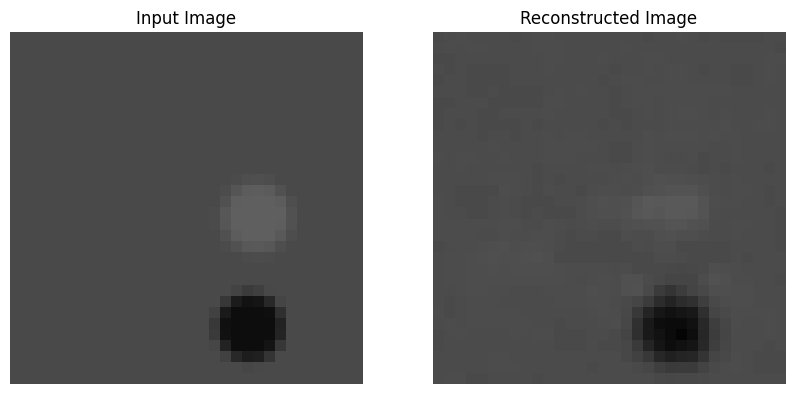

In [99]:
from utils.base_utils import to_01, to_0c
img_idx = 11

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

vae.eval()
xout, xin = vae(test_img)[0:2]
xout = xout.detach().cpu()
xin = xin.detach().cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(xin).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off");

ax[1].imshow(to_01(xout).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off");



tensor(-0.9783) tensor(-1.0666) tensor(0.8490) tensor(0.9498)
Test Loss: 0.0010


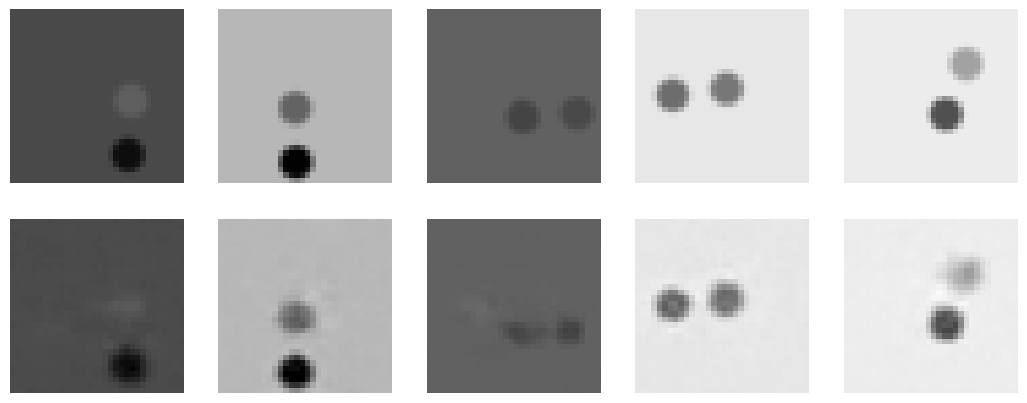

In [34]:
from utils.base_utils import to_01, to_0c
test_img = to_0c(data[11:16]).to(device)

vae.eval()
out = vae(test_img)
xout = out[0]
xin = out[1]
xout = xout.detach().cpu()
xin = xin.detach().cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(2, len(test_img), figsize=(13, 5))
for i in range(len(test_img)):
    ax[0, i].imshow(to_01(xin[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[0, i].set_title("Input Image")
    ax[0, i].axis("off");

    ax[1, i].imshow(to_01(xout[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[1, i].set_title("Reconstructed Image")
    ax[1, i].axis("off");


## covariance spectrum

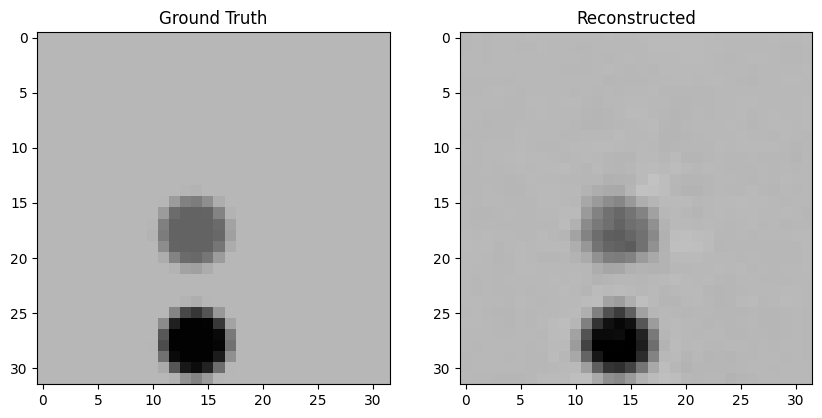

[[5 2 0 1 3 4]]


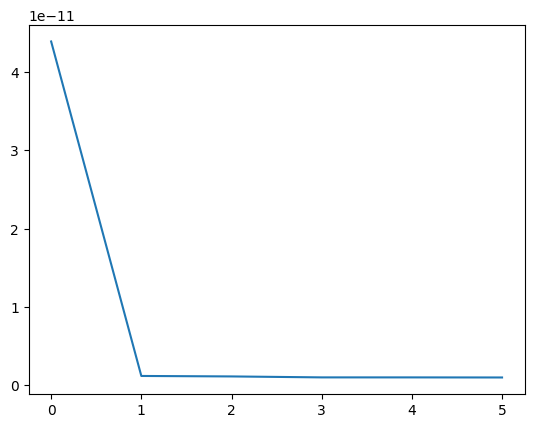

In [87]:
img_idx = 12

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

xhat_base = vae(test_img)[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(test_img).squeeze(0, 1).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(to_01(xhat_base).squeeze(0, 1).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
ax[1].set_title('Reconstructed')
plt.show()

z, mu, cov = vae.encoder(test_img)
cov = cov.detach().cpu().numpy()
cov_sort = np.flip(np.sort(cov, axis=1))
# get argsort
cov_argsort = np.flip(np.argsort(cov, axis=1))

fig, ax = plt.subplots(1, 1)
ax.plot(cov_sort.squeeze(0))
print(cov_argsort)

In [94]:
# now perturb along one axis and see what the decoded images look like
mu_base = mu.clone()
perturbations = np.linspace(-1, 1, 11)  # perturbations from -1 to 1 in 10 steps
perturbed_mus = torch.empty((len(perturbations), mu.shape[1])).to(device)

variance_mode = 0  # the index of the nth largest variance
for j in range(len(perturbations)):
    perturbed_mu = mu_base.clone()
    perturbed_mu[:, cov_argsort[0, variance_mode]] += perturbations[j]  # perturb by delta * 0.1 along the j-th axis
    perturbed_mus[j] = perturbed_mu.squeeze(0)

xhat_perturb = vae.decoder(perturbed_mus).squeeze(1)
print(xhat_perturb.shape)


torch.Size([11, 32, 32])


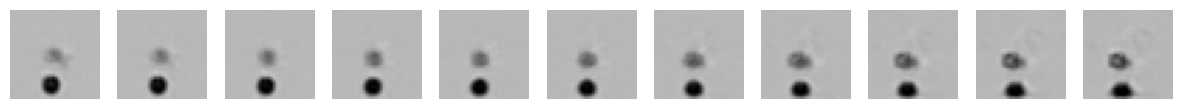

In [96]:
fig, ax = plt.subplots(1, len(perturbations), figsize=(15, 5))
for j in range(len(perturbations)):
    ax[j].imshow(to_01(xhat_perturb[j]).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
    ax[j].axis('off')
plt.show()
